In [13]:
import os
os.chdir(".")

from model import CNN_Model, LSTM_Model_RUL, CNN_Model_RUL, Net, Net_new, Autoencoder
from load_data import get_data, get_data_RUL_scenario1, get_discharge_capacities, get_dirs, NormalizeData, get_data_RUL_scenario2
from dataloader import battery_dataloader, battery_dataloader_RUL, get_RUL_dataloader
from import_file import *
from train_model import train_model, train_model_RUL, test_model_RUL, perform_n_folds
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from util_FPC import get_fpc_window, get_data, get_fpc, get_change_indices, EarlyStopping, plot_RUL, weight_reset

In [14]:
get_dirs()
discharge_capacities = get_discharge_capacities()

In [15]:
percentage  = 0.10  # 10 percent data
window_size = 50    # window size
stride = 1          # stride
channels  =[0,1,2,3,4,5,6] # channels


train_data,FPC_data,FPC_data_dict = get_data(discharge_capacities[:100],percentage,window_size,stride,channels,type = "train")
test_data,test_data_dict  = get_data(discharge_capacities[100:],None,window_size,stride,channels,type= "test")

obj_train  = battery_dataloader(train_data)
obj_FPC  = battery_dataloader(FPC_data)
obj_test  = battery_dataloader(test_data)


train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)


In [16]:
print("Number of Channels  :", channels)
print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)

Number of Channels  : [0, 1, 2, 3, 4, 5, 6]
Shape of a batch    : torch.Size([8, 7, 50])


In [17]:
epochs = 100
window_size = 50
learning_rate = 0.001

pretrained = True
load_pretrained = True
version = 1

ch = ''.join(map(str,channels))

model_dir = "./Weights/FPC/"
model_path = f'{model_dir}/model_f{ch}_f{window_size}_f{version}.pth'


if(pretrained):
    model = CNN_Model(window_size,len(channels))
    model.load_state_dict(torch.load(model_path, map_location=device ))
    model.to(device)
else:
    model = train_model(window_size,len(channels),train_dataloader,epochs,learning_rate,load_pretrained,model_path,version)


# Get Change Indices
change_indices_train,change_indices_test, _, _ = get_change_indices(model,discharge_capacities,channels)
change_indices_all = np.concatenate((change_indices_train,change_indices_test))

Loading Old Indices
Mean FPC for Training is 95.39598360469581and Test is 94.84584070881316


<Figure size 432x288 with 0 Axes>

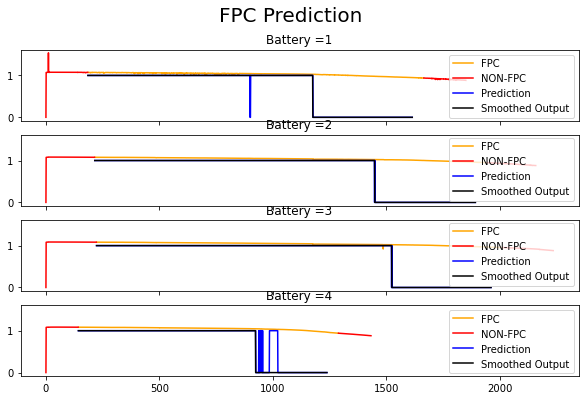

In [18]:
batteries = [i for i in range(0,4)]
_,_ = get_fpc(model,batteries,discharge_capacities,FPC_data_dict,True, True,True,"Outputs/FPC_Training")

<Figure size 432x288 with 0 Axes>

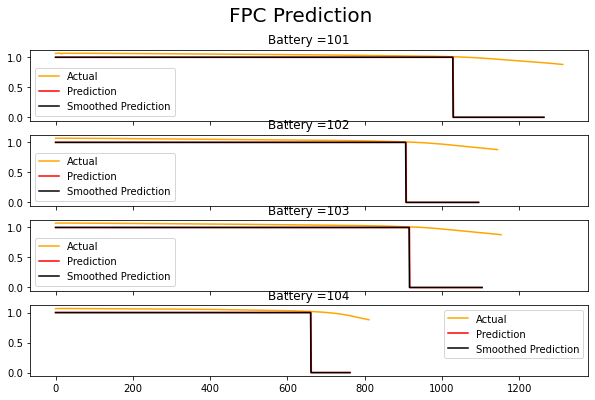

In [19]:
batteries = [i+100 for i in range(0,4)]
_,_ = get_fpc(model,batteries,discharge_capacities,test_data_dict,True, False,False,"Outputs/FPC_Testing")

In [20]:
# Model Testing
# transformer_model = Net()
# out,d = transformer_model(torch.rand((5,7,50)))

In [21]:
channels_RUL = [0,1,2,3,4,5,6]
window_size_RUL = 50
stride_RUL =1
c_RUL = ''.join(map(str,channels_RUL))


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
n_folds = 5
scenario = 1
learning_rate = 0.01
learning_rate = 0.0001
epochs = 40

parameters = {
    "window_size" : window_size,
    "stride": stride,
    "channels": channels_RUL,
    "epochs": epochs,
    "learning_rate": learning_rate
}



model_RUL = LSTM_Model_RUL(window_size,len(channels))  # LSTM Model
# model_RUL = Net()    # Transformer Model
#model_RUL = CNN_Model_RUL(window_size,channels)    # CNN Model

optimizer = torch.optim.Adam(model_RUL.parameters(), lr = learning_rate, betas= (0.9, 0.99))
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=50)

version = 1
pretrained_RUL_scenario1 = False
load_pretrained_scenario1  = False

model_dir_scenario1 = "./Weights/Scenario1/"
model_path_scenario1 = f'{model_dir_scenario1}/model_f{model.name}_f{c_RUL}_f{window_size_RUL}_f{version}.pth'

if(pretrained_RUL_scenario1):
    print("Loading a Pre-trained Model")
    model_RUL.load_state_dict(torch.load(model_path_scenario1,map_location= device))
else:
    if(load_pretrained_scenario1):
        print("Training further on already trained model")
        model_RUL.load_state_dict(torch.load(model_path_scenario1,map_location= device))
        perform_n_folds(model_RUL,n_folds,discharge_capacities,change_indices_all,criterion, optimizer, early_stopping,
                    pretrained_RUL_scenario1, model_path_scenario1,scenario,parameters, version)
    else:
        model_RUL, test_dataloader, test_batteries = perform_n_folds(model_RUL,n_folds,discharge_capacities,change_indices_all,criterion, optimizer, early_stopping,
                    pretrained_RUL_scenario1, model_path_scenario1,scenario,parameters, version)
    

    

50
*********************  Fold = 0  ********************* 


Epoch = 0, Loss = 0.2766590977828681 
Epoch = 1, Loss = 0.05243440125013248 
Epoch = 2, Loss = 0.05231177346083377 
Epoch = 3, Loss = 0.05216870738130105 
Epoch = 4, Loss = 0.05171093757401214 
Epoch = 5, Loss = 0.05073448040963562 
Epoch = 6, Loss = 0.047772215789279975 
Epoch = 7, Loss = 0.032081584757155904 
Epoch = 8, Loss = 0.006443074991050337 
Epoch = 9, Loss = 0.0062625784591690044 
Epoch = 10, Loss = 0.0061172470188958624 
Epoch = 11, Loss = 0.006251298777760654 
EarlyStopping counter: 1 out of 50
Epoch = 12, Loss = 0.006108630730554323 
Epoch = 13, Loss = 0.005987560252290296 
Epoch = 14, Loss = 0.005871965003394872 
Epoch = 15, Loss = 0.00590636774768518 
EarlyStopping counter: 1 out of 50
Epoch = 16, Loss = 0.005864989502593152 
Epoch = 17, Loss = 0.005853250995171187 
Epoch = 18, Loss = 0.005691411615344896 
Epoch = 19, Loss = 0.005634130027958976 
Epoch = 20, Loss = 0.005823824548448894 
EarlyStopping counter: 1

KeyboardInterrupt: 

In [ ]:
# batteries =[0,1,2]
# plot_RUL(model_RUL_scenario2,discharge_capacities,batteries,train_dataloader_RUL_temp_scenario2,change_indices_train,"scenario2_RUL_prediction_train")


In [ ]:
# test_batteries  = [i+100 for i in [16,17,18]]
# plot_RUL(model_RUL_scenario2,discharge_capacities,test_batteries,test_dataloader_RUL_scenario2,change_indices_test,"scenario2_RUL_prediction_test")

In [25]:
# test_batteries  = [i+100 for i in range(24)]
plot_RUL(model_RUL,discharge_capacities,test_batteries,test_dataloader,change_indices_all,"Outputs/scenario1_RUL_prediction_test")

NameError: name 'test_batteries' is not defined

In [ ]:
# batteries =[0,1,2,3]
# plot_RUL(model_RUL_scenario1,discharge_capacities,batteries,train_dataloader_RUL_temp_scenario1,change_indices_train,"scenario1_RUL_prediction_train")